In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [4]:
data = np.load('/kaggle/input/datasetchallengeann2/training_dataset/training_data.npy')
data.shape

(48000, 2776)

In [5]:
categories = np.load('/kaggle/input/datasetchallengeann2/training_dataset/categories.npy')
valid_indices = np.load('/kaggle/input/datasetchallengeann2/training_dataset/valid_periods.npy')
print(categories.shape)
print(valid_indices.shape)

(48000,)
(48000, 2)


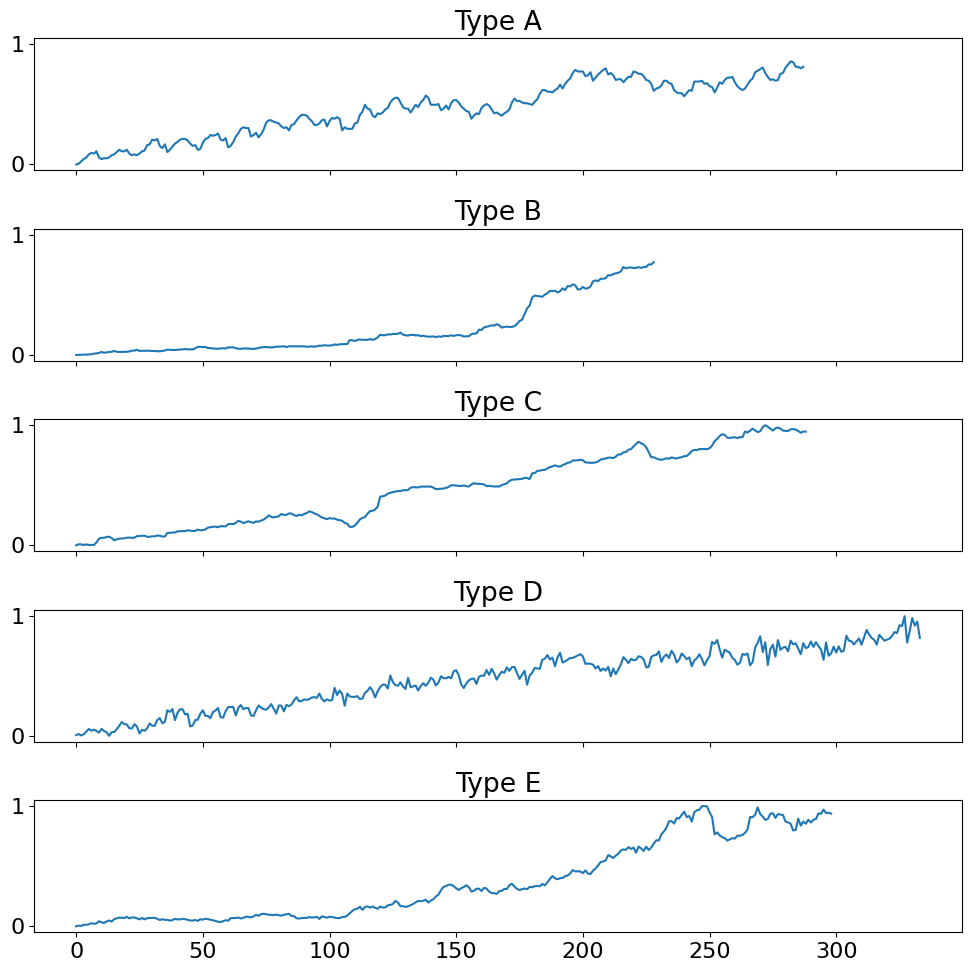

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_timeseries(data, labels, types=('A', 'B', 'C', 'D', 'E')):
    """
    Plot one random time series for each type specified in 'types'.

    Parameters:
    - data: numpy array of shape (num_time_series, time_series_length)
    - labels: numpy array of shape (num_time_series,) representing the type for each time series
    - types: tuple specifying the types to plot (default is ('A', 'B', 'C', 'D', 'E'))
    """
    # Create a figure with subplots for each type
    fig, axs = plt.subplots(len(types), 1, figsize=(10, 2 * len(types)), sharex=True, sharey=True)

    # Loop through each type and plot a random time series of that type
    for i, t in enumerate(types):
        # Get indices of time series with the specified type
        type_indices = np.where(labels == t)[0]
        
        # Select a random index for the given type
        random_index = np.random.choice(type_indices)
        
        # Extract the time series data
        time_series = data[random_index, valid_indices[random_index, 0]:]
        
        # Plot the time series
        axs[i].plot(time_series)
        axs[i].set_title(f'Type {t}')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

plot_random_timeseries(data, categories)

<h3>Training on model D</h3>

In [7]:
type_D_mask = (categories == "D") 
data_type_D = data[type_D_mask]
valid_indices_type_D = valid_indices[type_D_mask]

In [8]:
data_type_D.shape

(10016, 2776)

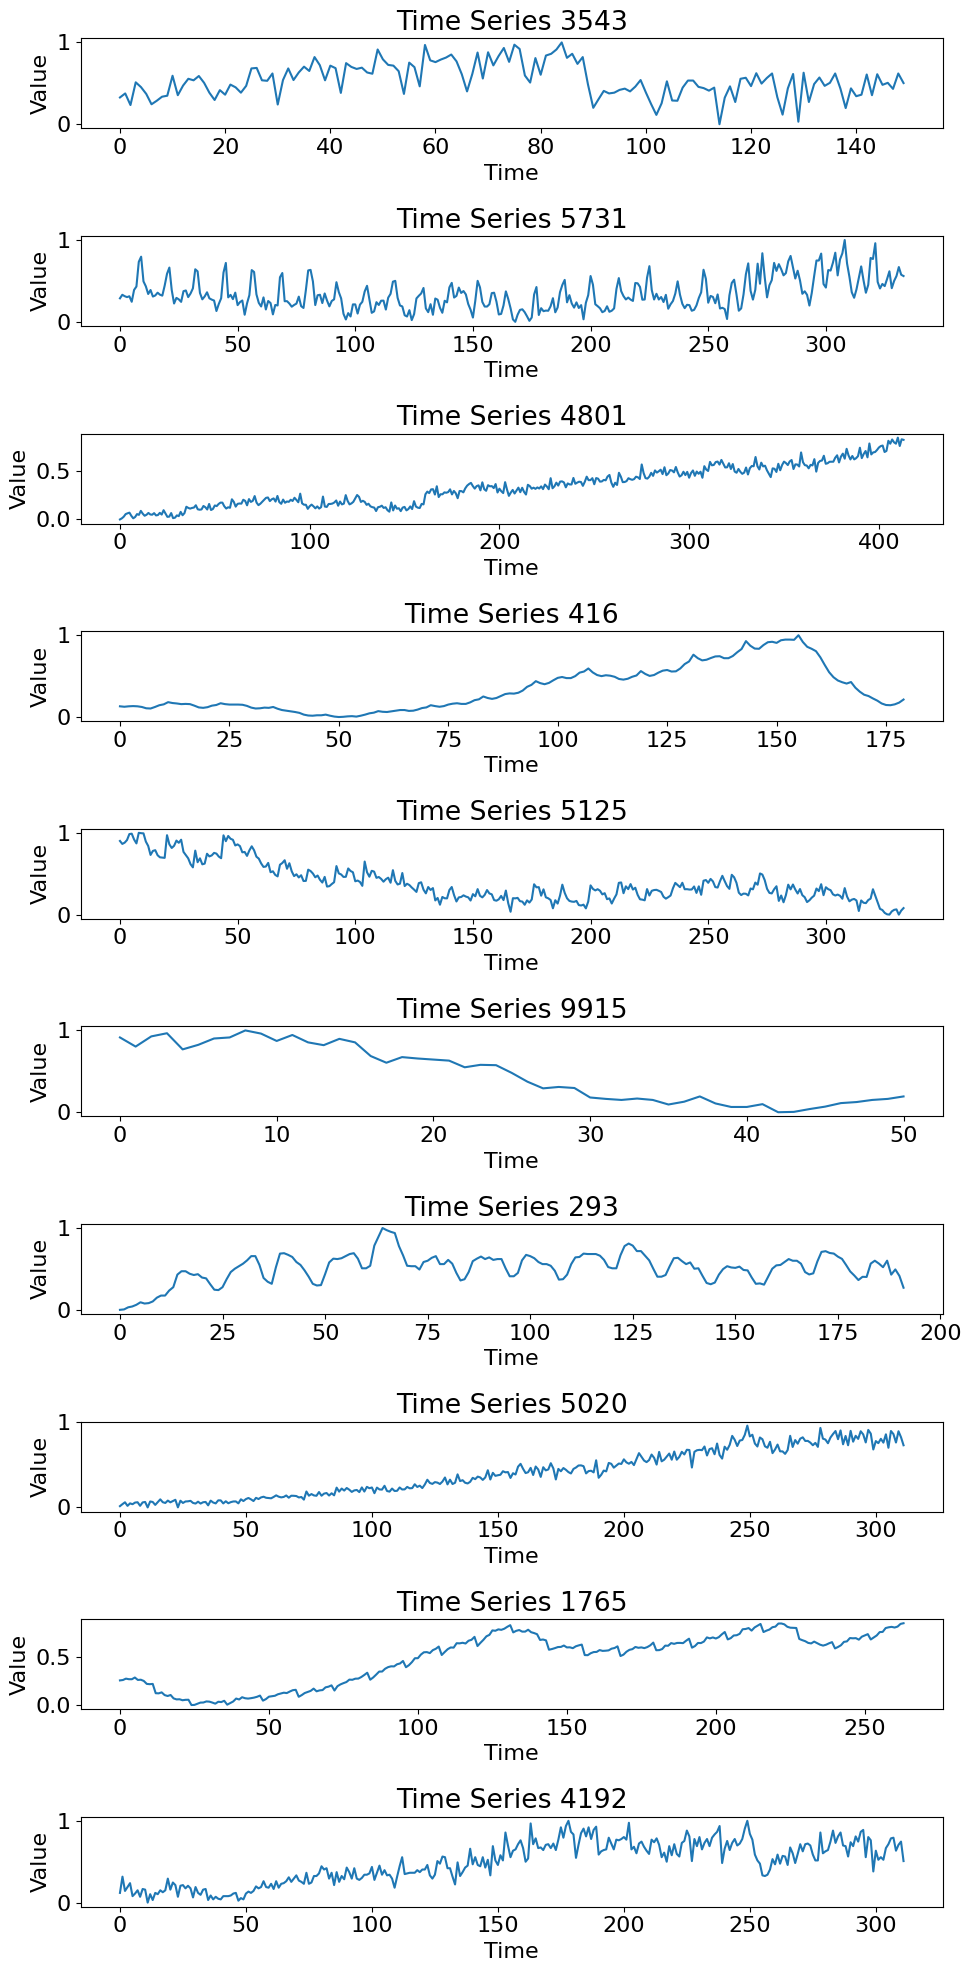

In [9]:

# Randomly select 10 time series indices
random_indices = np.random.choice(data_type_D.shape[0], 10, replace=False)

# Plot each selected time series in a separate subplot
num_plots = len(random_indices)
fig, axs = plt.subplots(num_plots, 1, figsize=(10, 2 * num_plots))

for i, index in enumerate(random_indices):
    axs[i].plot(data_type_D[index, valid_indices_type_D[index, 0]:])
    axs[i].set_title(f'Time Series {index}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [10]:
def build_sequences(df, window=100, stride=20, telescope=100):
    assert window % stride == 0
    dataset = []
    labels = []
    df = np.expand_dims(df, axis = -1)
    temp_df = np.copy(df)
    padding_check = len(df)%window

    if(padding_check != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros(( padding_len, temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_df[idx+window:idx+window+telescope])
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [11]:
from sklearn.model_selection import train_test_split
X_train_raw, X_validation_raw, valid_indices_train, valid_indices_validation = train_test_split(data_type_D, valid_indices_type_D, test_size = 0.2)
print(X_train_raw.shape, X_validation_raw.shape)

(8012, 2776) (2004, 2776)


In [12]:
print(valid_indices_train.shape)

(8012, 2)


In [13]:
lengths = []
for i in range(len(valid_indices_type_D)):
    lengths.append(valid_indices_type_D[i, 1]-valid_indices_type_D[i, 0])
lengths = np.array(lengths)

In [14]:
print(min(lengths), max(lengths))

42 2641


In [15]:
print(np.count_nonzero(lengths<200))

4383


In [16]:
autoregressive_telescope = 3

In [17]:
X_train = []
y_train = []
for i, time_series in enumerate(X_train_raw):
    dataset_tmp, labels_tmp = build_sequences(time_series[valid_indices_train[i, 0]:], window = 42, stride = 3, telescope = autoregressive_telescope)
    X_train.extend(dataset_tmp)
    y_train.extend(labels_tmp)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [18]:
X_val = []
y_val = []
for i, time_series in enumerate(X_validation_raw):
    dataset_tmp, labels_tmp = build_sequences(time_series[valid_indices_validation[i, 0]:], window = 42, stride = 3, telescope = autoregressive_telescope)
    X_val.extend(dataset_tmp)
    y_val.extend(labels_tmp)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [19]:
print(X_train.shape)
print(y_train.shape)

(512650, 42, 1)
(512650, 3, 1)


In [20]:
def inspect_multivariate(X, y, telescope, idx=None):
    random_indices = np.random.choice(X.shape[0], 10, replace=False)

    # Plot each selected time series in a separate subplot
    num_plots = len(random_indices)
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 2 * num_plots))

    for i, index in enumerate(random_indices):
        axs[i].plot(np.arange(len(X[0,:])), X[index,:])
        axs[i].scatter(np.arange(len(X[0,:]), len(X[0,:])+telescope), y[index,:], color='orange')
        axs[i].set_title(f'Time Series {index}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Value')

    plt.tight_layout()
    plt.show()

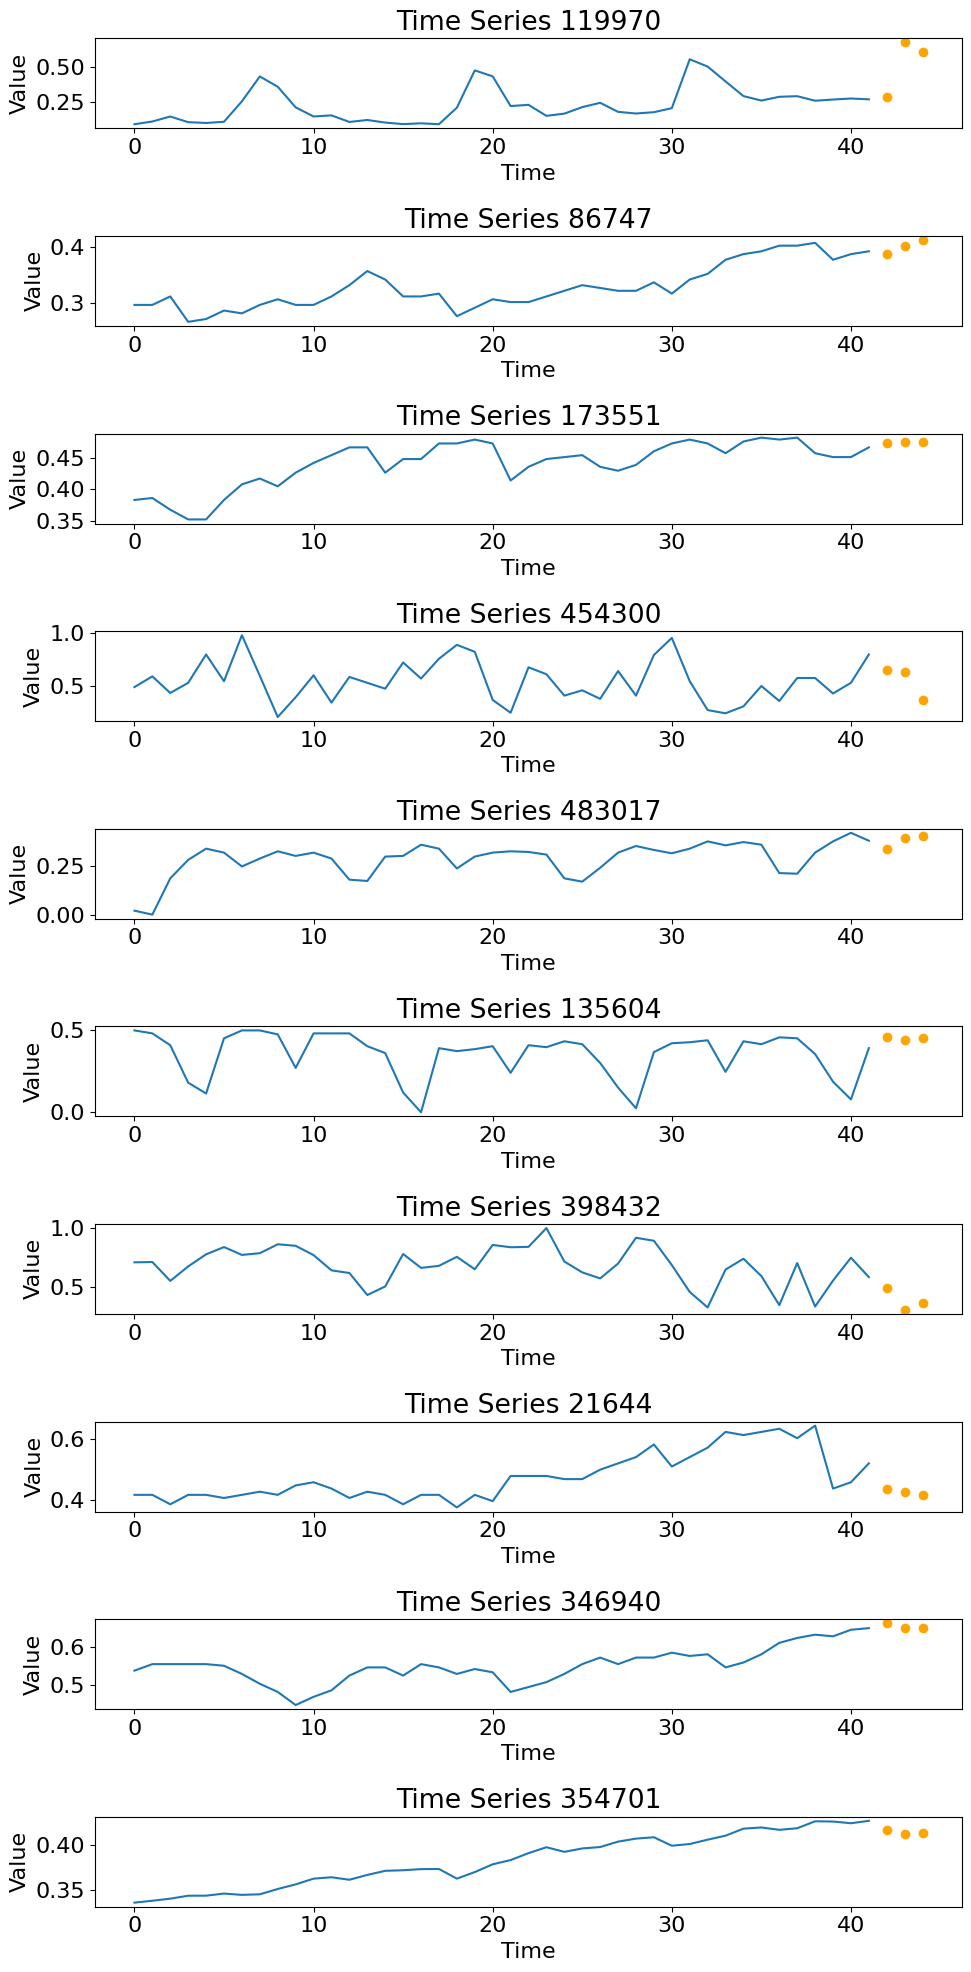

In [21]:
inspect_multivariate(X_train, y_train, autoregressive_telescope)

In [22]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [23]:
def build_CONV_LSTM_model(input_shape, output_shape):#merge convolution and lstm, to extract features and correlate in the time domain
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)
    
    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 42, 1)]           0         
                                                                 
 bidirectional_lstm (Bidire  (None, 42, 128)           33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 42, 128)           49280     
                                                                 
 output_layer (Conv1D)       (None, 42, 1)             385       
                                                                 
 cropping (Cropping1D)       (None, 3, 1)              0         
                                                                 
Total params: 83457 (326.00 KB)
Trainable params: 83457 (326.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

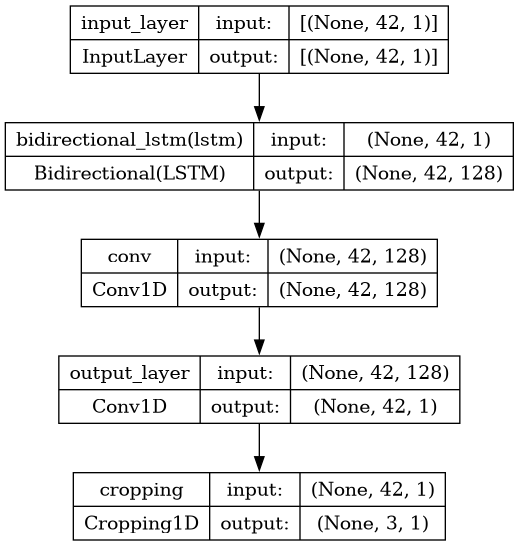

In [24]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [25]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
8011/8011 [==============================] - 79s 9ms/step - loss: 0.0094 - val_loss: 0.0066 - lr: 0.0010
Epoch 2/200
8011/8011 [==============================] - 67s 8ms/step - loss: 0.0066 - val_loss: 0.0063 - lr: 0.0010
Epoch 3/200
8011/8011 [==============================] - 67s 8ms/step - loss: 0.0062 - val_loss: 0.0060 - lr: 0.0010
Epoch 4/200
8011/8011 [==============================] - 67s 8ms/step - loss: 0.0060 - val_loss: 0.0056 - lr: 0.0010
Epoch 5/200
8011/8011 [==============================] - 67s 8ms/step - loss: 0.0058 - val_loss: 0.0056 - lr: 0.0010
Epoch 6/200
8011/8011 [==============================] - 67s 8ms/step - loss: 0.0058 - val_loss: 0.0059 - lr: 0.0010
Epoch 7/200
8011/8011 [==============================] - 67s 8ms/step - loss: 0.0057 - val_loss: 0.0055 - lr: 0.0010
Epoch 8/200
8011/8011 [==============================] - 67s 8ms/step - loss: 0.0056 - val_loss: 0.0054 - lr: 0.0010
Epoch 9/200
8011/8011 [==============================] - 70s 9ms

In [26]:
model.save("model_typeD.h5")